In [44]:
"""
Используется кристалл ниобата лития, формулы показателей преломления обыкновенной и необыкновенной волн приведены ниже.

Промоделировать процесс ГВГ 1550 + 1550 –> 775 на в PPLN длиной 1 см при температуре 350 К.

Найти длину домена, при которой осуществляется синхронизм. 

Построить кривые температурного и спектрального синхронизмов.
"""

'\nИспользуется кристалл ниобата лития, формулы показателей преломления обыкновенной и необыкновенной волн приведены ниже.\n\nПромоделировать процесс ГВГ 1550 + 1550 –> 775 на в PPLN длиной 1 см при температуре 350 К.\n\nНайти длину домена, при которой осуществляется синхронизм. \n\nПостроить кривые температурного и спектрального синхронизмов.\n'

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy import pi

In [46]:
#%% Параметры

lmbda1= 1550  # длина волны первой и второй гармоники в нм
lmbda2 = lmbda1 / 2

T = 350 # К
L = 1 # см

# формулы Сельмейера для обыкновенной и необыкновенной волн
def n_ord(lmbda, T):
    lmbda /= 1000 # в формулах Сельмейера длина волны в мкм
    return np.sqrt(4.913 + (0.1173 + 1.65e-8 * T**2)/(lmbda**2 - (
        0.212 + 2.7e-8 * T**2)**2) - 0.0278 * lmbda**2)

def n_ext(lmbda, T):
    lmbda /= 1000
    return np.sqrt(4.5567 + 2.605e-7 * T**2 + (0.097 + 2.7e-8 * T**2)/
                   (lmbda**2 - (0.201 + 5.4e-8 * T**2)**2) - 0.0224 * lmbda**2)

In [47]:
#%% Вычисления
k1 = 2 * pi * n_ext(lmbda1, T) / (lmbda1 / 1e7) # eee - тип синхронизма
k2 = 2 * pi * n_ext(lmbda2, T) / (lmbda2 / 1e7) 
    
dk = k2 - 2 * k1 # волновая расстройка
theta = pi / 2 # в кристаллах с РДС светим под 90 градусов
       
d_15 = 1.53e-7 # в СГС - коэффициенты в тензоре нелинейной восприимчивости     
d_22 = 7.38e-8 # по Никогосяну

# величина восприимчивости на нужных нам векторах
chi = d_15 * np.sin(theta) +  d_22 * np.cos(theta)
# chi = d_15  
sigma1 = 2 * pi * k1 * chi / n_ext(lmbda1, T)**2
sigma2 = 1 * pi * k2 * chi / n_ext(lmbda2, T)**2

period = 2 * pi / np.abs(dk) 
domain = period / 2 # длина домена в см
print('Длина домена в мкм, при которой осуществляется синхронизм:', domain*10**4)
N_domains = int(L//domain) # число доменов 
print(N_domains)

Длина домена в мкм, при которой осуществляется синхронизм: 9.417100705120676
1061


In [49]:
def SHG_solve(A0, dk, sigma1, sigma2, domain, N_domains ):
    A1 = complex(A0) # начальное поле 1 гармоники в ед. СГСЭ
    A2 = complex(0) # начальное поле 2 гармоники в ед СГСЭ
    
    A_calc = np.empty((2, 0))
    z_calc = np.array([])

    for N in range(N_domains):
        def SHG_calc(dk):        
            def shortened_eq(z, A):
                dA = np.zeros(2, dtype=complex)
                dA[0] = -1j * sigma1 * np.conjugate(A[0]) * A[1] * np.exp(
                    -1j * dk * z) * ((-1)**N) 
                dA[1] = -1j * sigma2  * A[0]**2 * np.exp(1j * dk * z) * ((-1)**N)
                return dA
            
            answer = solve_ivp(shortened_eq, [N * domain, (N + 1) * domain], 
                            [A1, A2], dense_output=True, rtol=1e-7, atol=1e-6)
                            
            return answer    
        
        answer = SHG_calc(dk)
        # каждый раз строим на новом промежутке
        z = np.linspace(N * domain, (N + 1) * domain, 50) 
        A = answer.sol(z)

        z_calc = np.concatenate((z_calc, z))
        A_calc = np.concatenate((A_calc, A), axis = 1)  

    
        # вносим амплитуды на выходе из одного домена 
        # в начальные условия для другого
        A1 = A[0][-1] 
        A2 = A[1][-1]
    return z_calc, A_calc


In [50]:

A0 = 1000
z_calc, A_calc = SHG_solve(A0, dk,sigma1, sigma2,  domain, N_domains )


Text(0, 0.5, 'Imaginary E')

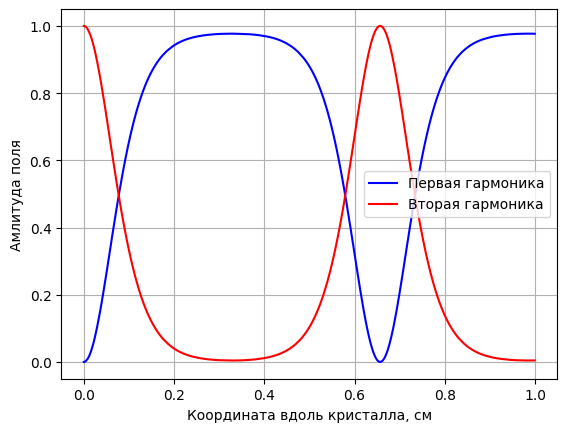

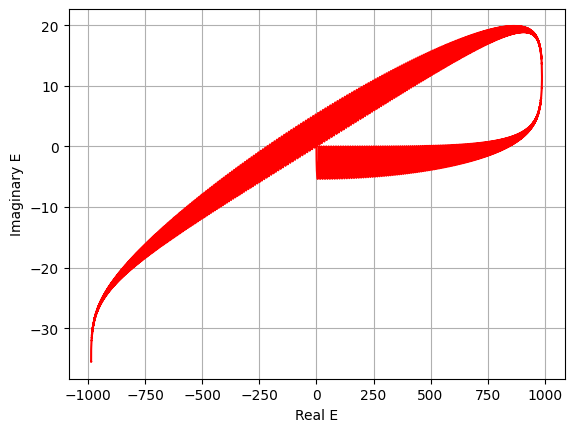

In [54]:
plt.figure('1', clear=False)   
plt.plot(z_calc, np.absolute(A_calc[1]) **2 / A0**2 , 'b', label = 'Первая гармоника')
plt.plot(z_calc, np.absolute(A_calc[0]) **2 / A0**2 , 'r', label = 'Вторая гармоника')
plt.legend()

plt.grid()
plt.xlabel('Координата вдоль кристалла, см')
plt.ylabel('Амлитуда поля')

# Фазовая диаграмма
plt.figure('2', clear=False)
plt.plot(A_calc[1].real, A_calc[1].imag, 'r')
plt.grid()
plt.xlabel('Real E')
plt.ylabel('Imaginary E')

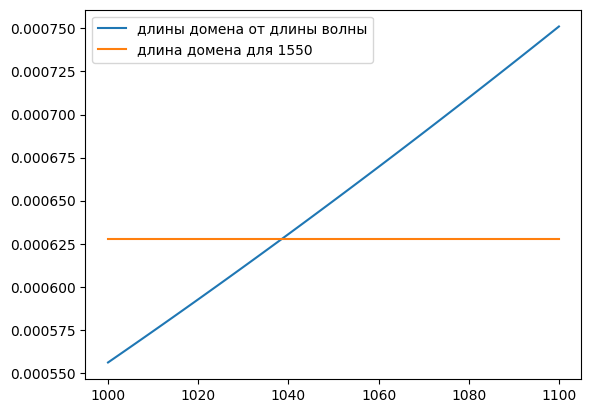

In [56]:
# ищем при какой длине волны длина домаена будет в 3 раза меньше чем длина для 1550
dl = 2 *  np.pi / dk 

# dk1 = dk/1
# dk3 = dk/3

n_lmbdas = np.linspace(1000, 1100, 100) #

n_dks = []
n_ls = []

for n_lmbda in n_lmbdas:

    n_lmbda1 = n_lmbda
    n_lmbda2 = n_lmbda/2

    n_k1 = 2 * pi * n_ext(n_lmbda1, T) / (n_lmbda1 / 1e7)
    n_k2 = 2 * pi * n_ext(n_lmbda2, T) / (n_lmbda2 / 1e7)     

    n_dk = n_k2 - 2 * n_k1
    n_dl = 2 * np.pi / n_dk

    n_dks.append(n_dk)
    n_ls.append(n_dl)

plt.plot(n_lmbdas, n_ls, label = 'длины домена от длины волны')
plt.plot(n_lmbdas, np.ones(len(n_lmbdas)) * dl / 3 , label = 'длина домена для 1550/3')
plt.legend()


In [36]:
492/500

0.984

In [57]:
#%% Температурный синхронизм Pin = 1e3 Вт
N_net = 50 # сетка
T_array = list(np.linspace(320, 380, N_net))
P_array = []
for t in T_array:
    # меняем величины в зависимости от температуры, длин домена неизменна
    k1 = 2 * pi * n_ext(lmbda1, t) / (lmbda1 / 1e7)
    k2 = 2 * pi * n_ext(lmbda2, t) / (lmbda2 / 1e7)        
    dk = k2 - 2 * k1
    
    sigma1 = 2 * pi * k1 * chi / n_ext(lmbda1, t)**2
    sigma2 = 1 * pi * k2 * chi / n_ext(lmbda2, t)**2

    P_in_1 = 1e3 # Вт
    A0 = 0.6 * np.sqrt(P_in_1)
    z_calc, A_calc = SHG_solve(A0, dk, sigma1, sigma2, domain, N_domains)
    
    P_array.append(np.absolute((A_calc[1, -1]) /0.6) ** 2) # выходная мощность ВГ
    




In [38]:
#%% Температурный синхронизм Pin = 1e5 Вт
N_net = 50 # сетка
T_array = list(np.linspace(320, 380, N_net))
P_array_2 = []
for t in T_array:
    # меняем величины в зависимости от температуры, длин домена неизменна
    k1 = 2 * pi * n_ext(lmbda1, t) / (lmbda1 / 1e7)
    k2 = 2 * pi * n_ext(lmbda2, t) / (lmbda2 / 1e7)        
    dk = k2 - 2 * k1
    
    sigma1 = 2 * pi * k1 * chi / n_ext(lmbda1, t)**2
    sigma2 = 1 * pi * k2 * chi / n_ext(lmbda2, t)**2

    P_in_2 = 1e5 # Вт
    A0 = 0.6 * np.sqrt(P_in_2)
    z_calc, A_calc = SHG_solve(A0, dk, sigma1, sigma2, domain, N_domains)
    
    P_array_2.append(np.absolute((A_calc[1, -1]) /0.6) ** 2) # выходная мощность ВГ
    




In [58]:
#%% Температурный синхронизм от лямбды(сдвиг на 2 нм)
N_net = 50 # сетка

T_array = list(np.linspace(320, 380, N_net))
P_array_3 = []

for t in T_array:
    # меняем величины в зависимости от температуры, длин домена неизменна
    k1 = 2 * pi * n_ext(lmbda1+2, t) / ((lmbda1+2) / 1e7)
    k2 = 2 * pi * n_ext(lmbda2+1, t) / ((lmbda2+1) / 1e7)        
    dk = k2 - 2 * k1
    
    sigma1 = 2 * pi * k1 * chi / n_ext(lmbda1+2, t)**2
    sigma2 = pi * k2 * chi / n_ext(lmbda2+1, t)**2
    P_in_3 = 1e5 # Вт
    
    A0 = 0.6 * np.sqrt(P_in_2)
    z_calc, A_calc = SHG_solve(A0, dk, sigma1, sigma2, domain, N_domains)
    P_array_3.append(np.absolute((A_calc[1, -1]) /0.6) ** 2) # выходная мощность ВГ
    




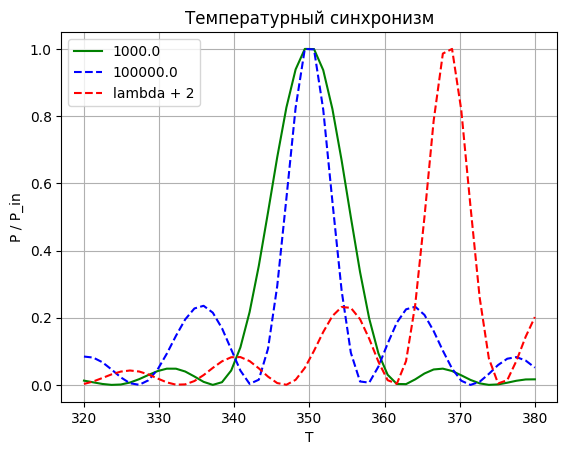

In [40]:
plt.figure('temp_sync', clear=True)
# plt.plot(T_array, P_array / np.max(P_array), 'g')
# plt.plot(T_array, P_array_2 / np.max(P_array_2), 'b')
plt.plot(T_array, np.array(P_array) / np.max(P_array) , 'g', label = str(P_in_1))
plt.plot(T_array, np.array(P_array_2) / np.max(P_array_2), 'b--', label = str(P_in_2))
plt.plot(T_array, np.array(P_array_3) / np.max(P_array_3), 'r--', label = 'lambda + 2')
# plt.plot(T_array, np.array(P_array) / P_in_1 , 'g', label = str(P_in_1))
# plt.plot(T_array, np.array(P_array_2) / P_in_2, 'b--', label = str(P_in_2))
plt.legend()
plt.xlabel('T')
plt.ylabel('P / P_in')
plt.title('Температурный синхронизм')
plt.grid()

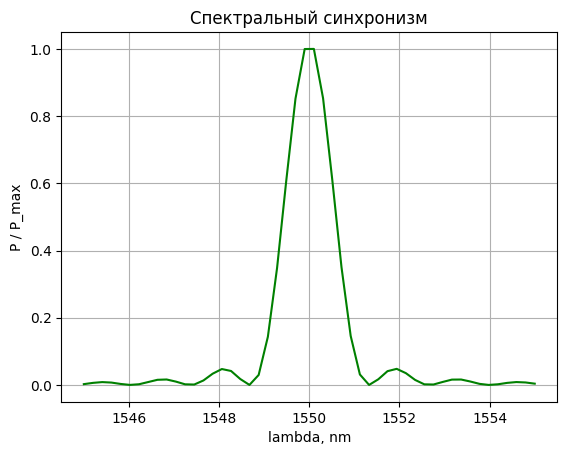

In [41]:
#%% Спектральный синхронизм
l_array = list(np.linspace(1545, 1555, N_net))
P_array_l = []
for ll in l_array:
    k1 = 2 * pi * n_ext(ll, T) / (ll / 1e7)
    k2 = 2 * pi * n_ext(ll / 2, T) / (ll / 2 / 1e7)        
    dk = k2 - 2 * k1
    
    sigma1 = 2 * pi * k1 * chi / n_ext(ll, T)**2
    sigma2 = pi * k2 * chi / n_ext(ll, T)**2
    P_in = 1 # Вт
    A0 = 0.6 * np.sqrt(P_in)
    z_calc, A_calc = SHG_solve(A0, dk, sigma1, sigma2, domain, N_domains)
    P_array_l.append(np.absolute(A_calc[1, -1]) ** 2) # выходная мощность ВГ

plt.figure('spec_sync', clear=True)
plt.plot(l_array, P_array_l / np.max(P_array_l), 'g')
plt.xlabel('lambda, nm')
plt.ylabel('P / P_max')
plt.title('Спектральный синхронизм')
plt.grid()

In [42]:
# что будет если учитывать температурное самовоздействие, поглощение второй гармоники в кристалле
# есть ли здесь крутилка, которая позвляет сильно но дискретно двигать длину волны